# **AstrID:**  *model training*

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from astropy.io import fits

# Import custom functions to extract Image arrays and Pixel Mask arrays from our created fits files dataset
from dataGathering import extractImageArray, extractPixelMaskArray, extract_star_catalog
from dataGathering import getStarData, getImagePlot, getPixelMaskPlot
from dataGathering import displayRawImage, displayRawPixelMask, displayImagePlot, displayPixelMaskPlot, displayPixelMaskOverlayPlot

# Import custom functions to preprocess Image and Pixel Mask arrays
from imageProcessing import normalizeImages, stackImages, stackMasks, preprocessImage

# Import custom logging function
from log import write_to_log


2024-11-03 16:52:46.847561: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 16:52:46.847984: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-03 16:52:46.850185: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-03 16:52:46.857505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730681566.870775   60048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730681566.87

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-11-03 16:52:49.268926: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    
    # Clear GPU memory
    K.clear_session()
    tf.config.experimental.reset_memory_stats('GPU:0')

### UnSu Unet Object Localization

In [4]:
# Encoder path
    #32 kernels
    #3x3 kernel size
    #padding = same considers edges in the input
# Example function to create a U-Net model
def unet_model(input_shape, filters, kernel_size, activation, padding, initializer):
    inputs = layers.Input(input_shape)

    # Encoder path
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(inputs)
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p1)
    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p2)
    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p3)
    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p4)
    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c5)

    # Decoder path
    u6 = layers.Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding=padding)(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u6)
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c6)

    u7 = layers.Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding=padding)(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u7)
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c7)

    u8 = layers.Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding=padding)(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u8)
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c8)

    u9 = layers.Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding=padding)(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u9)
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [5]:
# getStarData('II/246', 250, 'data')

In [6]:
# Create images and masks arrays lists
images = []
masks = []

# Create df to store the star data inside each fits file
star_data = []

# Create a list of all the fits files in the dataset folder
fits_files = os.listdir('data/fits/')

# For all the fits files in the dataset folder specified in file_path, extract the image and mask arrays to the respective lists
file_path = 'data/fits/'
# for file in os.listdir(file_path):
for file in os.listdir(file_path):
    if file.endswith('.png'):
        os.remove(file_path + file)
    if file.startswith('data') and file.endswith('.fits'):
        images.append(extractImageArray(file_path + file))
        masks.append(extractPixelMaskArray(file_path + file))
        star_data.append(extract_star_catalog(file_path + file))

        print(file + ' added to dataset')

data20.fits added to dataset
data223.fits added to dataset
data111.fits added to dataset
data231.fits added to dataset
data5.fits added to dataset
data224.fits added to dataset
data122.fits added to dataset
data7.fits added to dataset
data136.fits added to dataset
data11.fits added to dataset
data0.fits added to dataset
data178.fits added to dataset
data201.fits added to dataset
data116.fits added to dataset
data2.fits added to dataset
data35.fits added to dataset
data39.fits added to dataset
data37.fits added to dataset
data160.fits added to dataset
data114.fits added to dataset
data230.fits added to dataset
data69.fits added to dataset
data142.fits added to dataset
data135.fits added to dataset
data101.fits added to dataset
data6.fits added to dataset
data100.fits added to dataset
data156.fits added to dataset
data180.fits added to dataset
data232.fits added to dataset
data28.fits added to dataset
data48.fits added to dataset
data155.fits added to dataset
data125.fits added to datase

# Prepare the data for training

### Convert to 3-Channel Images

The images we have are 512 x 512 pixels, but our model requires them to be in the shape `(512, 512, 3)`, similar to standard RGB images. To achieve this, we stack the single-channel images along the last axis three times, converting them into 3-channel images. This transformation is necessary because the model typically expects 3-channel input images.

For the masks, the model expects them to be in the shape `(512, 512, 1)`. Therefore, we expand the masks along the last axis to add a new dimension, ensuring they have the correct shape.

Additionally, both the images and masks need to be converted to NumPy arrays, as this is the desired format for the training model. Below, we perform these conversions to ensure the data is in the correct format for training.

Notice when displaying the shape of the `train_images` list below we see it is an array of 250 images of the shape mentioned above, giving us a shape `(250, 512, 512, 3)`

In [7]:
stacked_images = stackImages(images)
stacked_masks = stackMasks(masks)

### Normalize the Images

To standardize the pixel values in our images, we need to normalize them to a common range.
We will use min-max normalization to scale the pixel values to a range between 0.0 and 1.0.

In [8]:
normalized_images = normalizeImages(stacked_images)

0.0 1.0


###  Prepare the model for training


In [ ]:
#############################################

# Define the base exponent - Change this number to increase or decrease the number of filters by a power of 2
base_exponent = 5
#############################################
# base_exponent = 5, so filters result in [32, 64, 128, 256, 512], this was the original value
# base_exponent = 6, so filters result in [64, 128, 256, 512, 1024]
# base_exponent = 7, so filters result in [128, 256, 512, 1024, 2048]
# base_exponent = 8, so filters result in [256, 512, 1024, 2048, 4096]
# base_exponent = 9, so filters result in [512, 1024, 2048, 4096, 8192]
# base_exponent = 10, so filters result in [1024, 2048, 4096, 8192, 16384]

# Generate the filters based on powers of 2
filters = [2 ** (base_exponent + i) for i in range(5)]
#############################################
# This list comprehension generates the filter sizes by raising 2 to the powers starting from the base exponent and increasing by 1 for each subsequent filter.
#############################################

# Define hyperparameters
hyperparameters = {
    'input_shape': (512, 512, 3),
    'filters': filters,
    'kernel_size': (3, 3),
    'activation': 'relu',
    'padding': 'same',
    # 'initializer': he_uniform(),
    'initializer': he_uniform,
    'optimizer': 'adam',
    # 'loss': weightedBinaryCrossEntropy,
    'loss': 'binary_crossentropy',
    'weights' : {0 : 1.0, 1 : 5.0},
    'metrics': ['accuracy'],
    'epochs': 100,
    'batch_size': 4,
    'early_stopping_patience': 10,
    'test_size': 0.2,
    'random_state': 0,
    'seed': 42
}

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)
model.compile(
    optimizer=hyperparameters['optimizer'],
    loss=hyperparameters['loss'],
    metrics=hyperparameters['metrics']
)

**Create Generators for Training and Validation**:
   - Use the `flow` method to create generators for training and validation images and masks.
   - Ensure that the `seed` parameter is the same for both image and mask generators to maintain alignment.

 **Custom Generator**:
   - Define a custom generator function `custom_generator` that yields a tuple (images, masks, sample_weights).

In [10]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(normalized_images, stacked_masks, test_size=hyperparameters['test_size'], random_state=hyperparameters['random_state'])

In [11]:
# Compute sample weights for the masks
def compute_sample_weights(masks, class_weight):
    sample_weights = np.zeros(masks.shape)
    for class_value, weight in class_weight.items():
        sample_weights[masks == class_value] = weight
    return sample_weights

train_sample_weights = compute_sample_weights(train_masks, hyperparameters['weights'])
val_sample_weights = compute_sample_weights(val_masks, hyperparameters['weights'])


In [12]:
# Custom data generator to yield images, masks, and sample weights together
# This is the same as the ImageDataGenerator class but with an additional sample_weights parameter and a seed parameter
class CustomDataGenerator(ImageDataGenerator):
    def __init__(self, sample_weights, seed=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sample_weights = sample_weights
        self.seed = seed

    def flow(self, x, y, *args, **kwargs):
        for batch in super().flow(x, y, seed=self.seed, *args, **kwargs):
            batch_x, batch_y = batch
            batch_sample_weights = self.sample_weights[:len(batch_x)]
            yield batch_x, batch_y, batch_sample_weights

In [13]:
# Create data generators
train_datagen = CustomDataGenerator(sample_weights=train_sample_weights, seed=hyperparameters['seed'])
val_datagen = CustomDataGenerator(sample_weights=val_sample_weights, seed=hyperparameters['seed'])

train_generator = train_datagen.flow(train_images, train_masks, batch_size=hyperparameters['batch_size'])
val_generator = val_datagen.flow(val_images, val_masks, batch_size=hyperparameters['batch_size'])

# Show distribution of training and validation sets
print('Training images: ', train_images.shape)
print('Training masks: ', train_masks.shape)
print('Validation images: ', val_images.shape)
print('Validation masks: ', val_masks.shape)

Training images:  (200, 512, 512, 3)
Training masks:  (200, 512, 512, 1)
Validation images:  (50, 512, 512, 3)
Validation masks:  (50, 512, 512, 1)


# Train the model

In [14]:
from sklearn.utils import class_weight

# Implement Early stopping to cut useless epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric like 'val_accuracy'
    patience=hyperparameters['early_stopping_patience'],         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the model to the best state after stopping
)


# # Train the model
# history = model.fit(
#     train_images, train_masks, 
#     validation_data=(val_images, val_masks), 
#     epochs=hyperparameters['epochs'], 
#     batch_size=hyperparameters['batch_size'],
#     callbacks=[early_stopping],
#     class_weight=hyperparameters['weights']
# )


# # Train the model
# history = model.fit(
#     train_images, train_masks,
#     validation_data=(val_images, val_masks, val_sample_weights),
#     epochs=hyperparameters['epochs'],
#     batch_size=hyperparameters['batch_size'],
#     callbacks=[early_stopping],
#     sample_weight=train_sample_weights
# )


# Train the model
history = model.fit(
    train_generator, 
    validation_data=val_generator,
    epochs=hyperparameters['epochs'],
    steps_per_epoch=len(train_images) // hyperparameters['batch_size'],
    validation_steps=len(val_images) // hyperparameters['batch_size'],
    callbacks=[early_stopping],
)




/home/ethan/GitHub/AstrID/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 935s 19s/step - accuracy: 0.9062 - loss: 0.3053 - val_accuracy: 0.9936 - val_loss: 0.0448


In [15]:
# Save the model
saved_models_path = 'models/saved_models/'
training_size = str(len(train_images))
saved_model_name = datetime.datetime.now().strftime("%Y_%m_%d-%H%M_") + training_size + '_unet_model.keras'
# model.save(saved_models_path + saved_model_name)

#log model parameters, time, and user
write_to_log(history, hyperparameters, saved_model_name)

In [16]:
# Show training loss and validation loss
print('Training loss: ', history.history['loss'][-1])
print('Validation loss: ', history.history['val_loss'][-1])

# Show training accuracy and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

Training loss:  0.13710016012191772
Validation loss:  0.04475864768028259
Training accuracy:  0.974591851234436
Validation accuracy:  0.9936471581459045


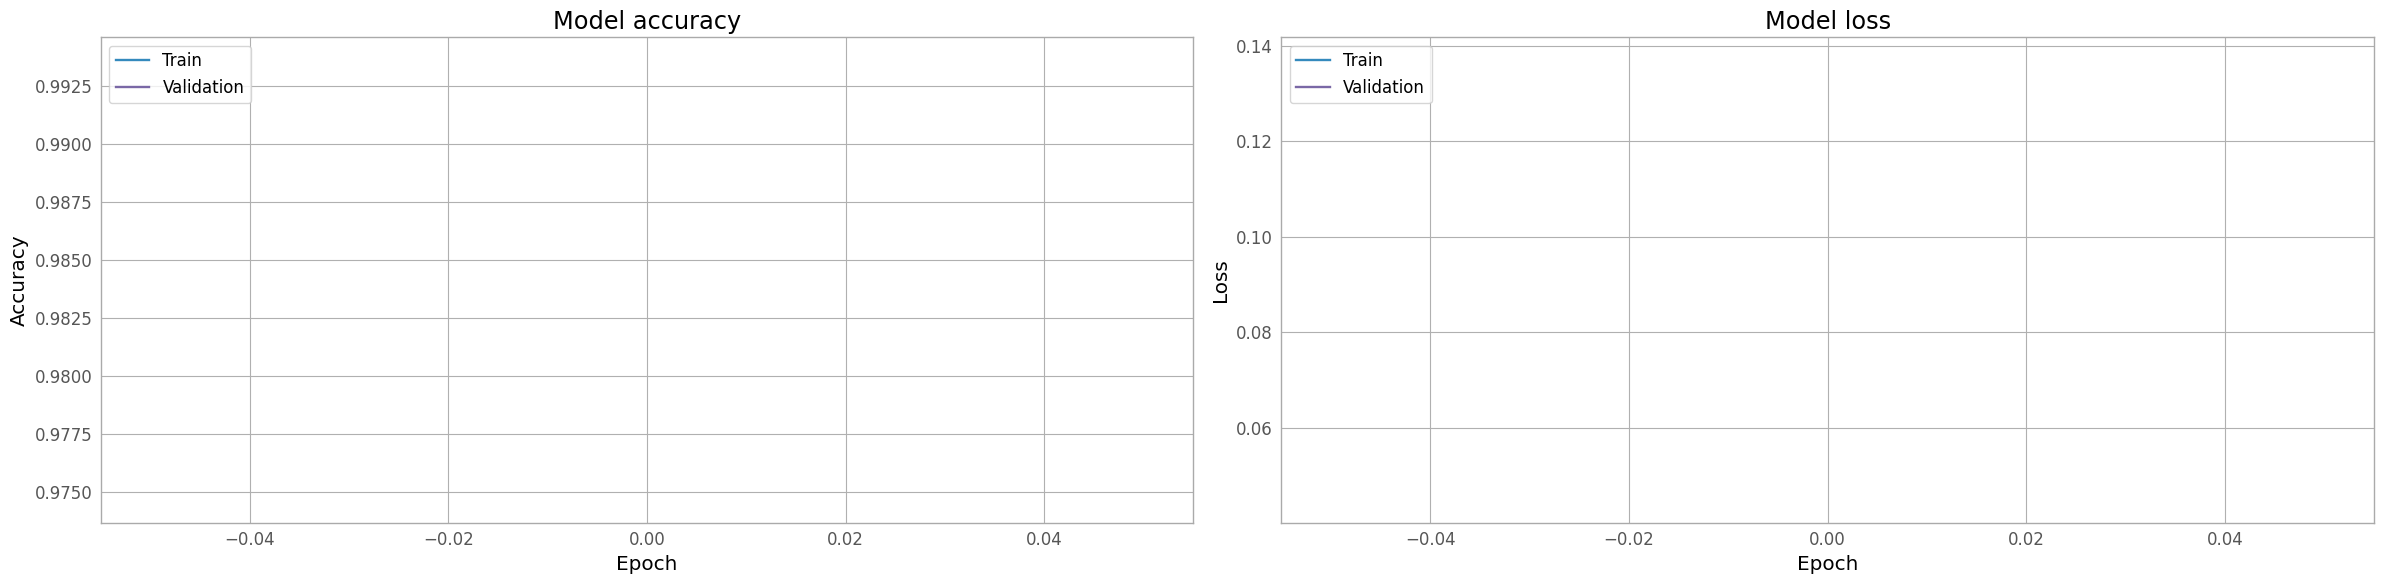

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
# plt.savefig('results/figures/' + saved_model_name.removesuffix('unet_model.keras') + '_training_validation.png')
plt.show()

/tmp/ipykernel_60048/2291984298.py:20: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch


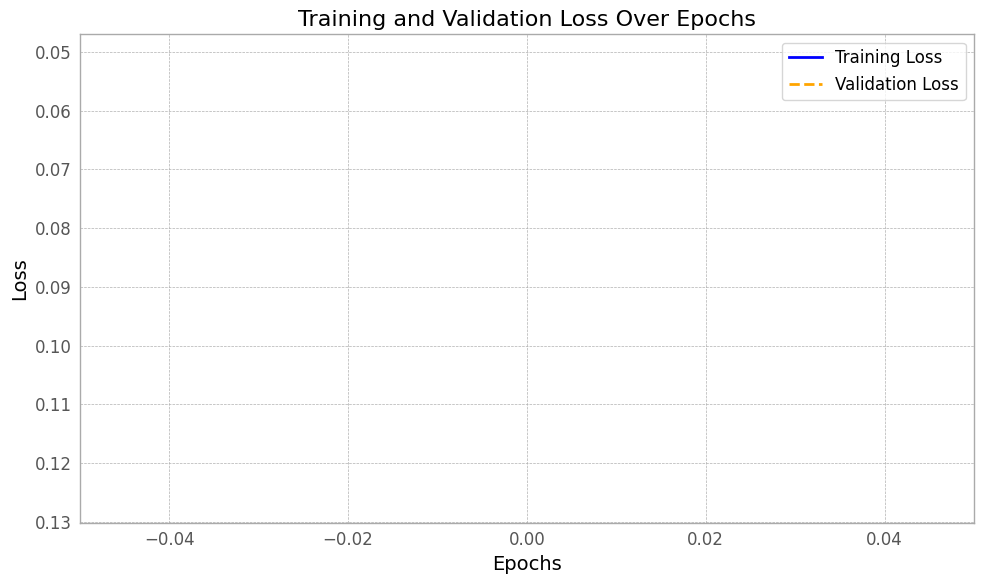

In [18]:
# Set a larger figure size
plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to differentiate between training and validation loss
plt.legend(loc='best', fontsize=12)

# Set limits for better visualization
plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch
plt.ylim(min(history.history['loss']) * 0.95, max(history.history['val_loss']) * 1.05)

# Show the plot
plt.tight_layout()
# plt.savefig('results/figures/' + saved_model_name.removesuffix('unet_model.keras') + '_training_validation_loss.png')
plt.show()
